In [23]:
# Import Python libraries
import os
import warnings
import time
import joblib
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML

In [24]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
set_config(display='diagram')

In [25]:
data = pd.read_csv('StackOverflow_cleaned.csv',sep=";", index_col=0,converters={"Title": literal_eval,
                                                                                 "Body": literal_eval,
                                                                                  "Tags": literal_eval})

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24044 entries, 0 to 27048
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   24044 non-null  object
 1   Body    24044 non-null  object
 2   Score   24044 non-null  int64 
 3   Tags    24044 non-null  object
dtypes: int64(1), object(3)
memory usage: 939.2+ KB


In [27]:
#data=data[0:5000]

In [28]:
data

,Title,Body,Score,Tags
0,"[core, dump, linux, segmentation, fault]","[process, linux, segmentation, fault, core, dump]",237,"[linux, bash]"
1,"[php, server, mysql, server, time, zone]","[hosting, package, godaddy, network, solution,...",12,"[php, mysql]"
2,"[constraint, landscape, orientation]","[constraint, device, example, image, portrait,...",48,"[ios, cocoa-touch]"
3,"[loading, system, servicemodel, configuration,...","[net, wcf, wcf, configuration, client, applica...",64,"[c#, .net]"
4,"[xml, serialization, inherited, type]","[question, object, model, xml, problem, quelle...",86,[c#]
...,...,...,...,...
27043,"[python, process, pdf, report, chart]","[database, survey, university, professor, pyth...",41,"[python, pandas]"
27044,"[network, connection, type, android, pie]","[android, pie, request, encryption, default, s...",192,"[java, android]"
27045,"[react, router, position, component]","[react, router, card, list, card, game, detail...",28,[javascript]
27046,"[operation, library]","[project, crash, request, page, problem, docum...",46,"[ios, swift]"


LDA :


In [29]:
X = data["Body"]
y = data["Tags"]
# Create dictionnary (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [30]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('core', 1),
  ('dump', 1),
  ('fault', 1),
  ('linux', 1),
  ('process', 1),
  ('segmentation', 1)]]

In [31]:
# Create dictionnary (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [32]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('core', 1),
  ('dump', 1),
  ('fault', 1),
  ('linux', 1),
  ('process', 1),
  ('segmentation', 1)]]

In [33]:
# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,90,10):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 11
Fitting LDA for K = 21
Fitting LDA for K = 31
Fitting LDA for K = 41
Fitting LDA for K = 51
Fitting LDA for K = 61
Fitting LDA for K = 71
Fitting LDA for K = 81


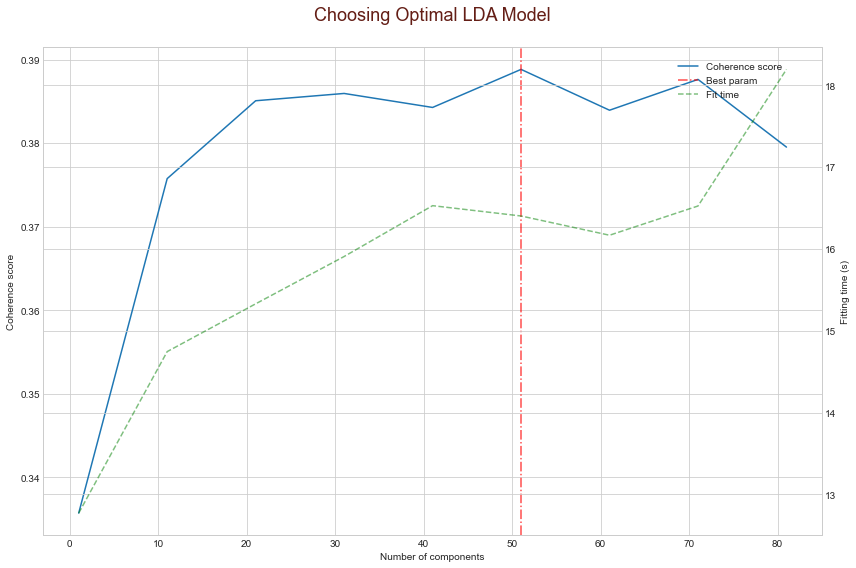

In [34]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test.loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Choosing Optimal LDA Model\n",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

In [35]:
# Best LDA visualization
# Construire le modèle LDA
best_lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=best_nb_topics,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
                                  
gensimvis.prepare(best_lda_model, corpus, id2word)

C:\Users\Aeorn\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
42    -0.012640  0.006230       1        1  3.139162
38     0.015073 -0.036465       2        1  3.108955
49     0.030165  0.068666       3        1  3.089513
0     -0.055211  0.020242       4        1  3.067166
50     0.052199 -0.024937       5        1  3.027307
7     -0.051133 -0.009256       6        1  2.979296
17     0.012663 -0.037061       7        1  2.721742
6      0.020153  0.023041       8        1  2.547926
46     0.031317  0.079751       9        1  2.536147
30     0.090398 -0.040543      10        1  2.461054
23    -0.110292 -0.030964      11        1  2.457505
44    -0.061254  0.023519      12        1  2.423506
39    -0.008615 -0.008795      13        1  2.242834
15    -0.011084  0.042254      14        1  2.135237
1     -0.007519 -0.043471      15        1  2.122801
14    -0.040008 -0.035759      16        1  2.036239
4      0.014711

In [36]:
# Calculate Document/topic matrix with Gensim
doc_topic = pd.DataFrame(best_lda_model.get_document_topics(corpus,minimum_probability=0))

for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])


# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)


print('document/tag : ', y_binarized.shape)
print('document/topic : ', doc_topic.shape)

document/tag :  (24044, 50)
document/topic :  (24044, 51)


In [37]:
# Print documents / topic matrix
doc_topic.head(3)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802,...,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802
1,0.001033,0.001033,0.001033,0.001033,0.001033,0.001033,0.001033,0.001033,0.001033,0.001033,...,0.287469,0.001033,0.001033,0.001033,0.001033,0.001033,0.001033,0.001033,0.001033,0.001033
2,0.001307,0.001307,0.001307,0.001307,0.001307,0.001307,0.001307,0.001307,0.001307,0.001307,...,0.001307,0.001307,0.001307,0.001307,0.001307,0.200493,0.001307,0.001307,0.735450,0.001307


In [38]:
# Matricial multiplication with Document / Topics transpose
topic_tag = np.matmul(doc_topic.T, y_binarized)
topic_tag.shape

(51, 50)

In [39]:
topic_tag

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,38.776241,2.648528,30.184705,30.645687,15.751647,3.693181,2.023553,3.479807,99.880817,72.139478,...,3.632244,17.058147,8.363363,3.911370,19.008690,16.303594,6.885970,3.716193,1.949096,9.007730
1,26.314133,8.886952,5.152193,38.363491,7.246209,11.700643,6.217704,2.541329,25.968033,37.258226,...,4.113004,10.333204,7.177035,10.918978,5.893465,11.099512,0.842746,9.367724,1.211324,7.185132
2,34.449529,20.298637,7.607236,17.752136,4.208887,11.281491,8.589918,30.781501,10.515869,54.527197,...,24.953437,5.663713,9.649437,4.593577,36.697946,11.118883,1.088222,10.395328,2.901158,9.464425
3,19.166008,5.880154,5.086374,40.530537,4.308532,10.368544,6.086086,6.048079,8.514129,32.608662,...,3.646682,1.518042,3.250546,0.916825,4.280319,4.880882,4.870696,8.442199,4.069307,27.763010
4,20.438585,0.675195,6.567599,19.381183,4.186873,3.582614,5.105976,6.849764,19.853450,39.301130,...,3.798262,6.823433,7.875411,3.991840,5.771479,11.734523,29.258999,10.797330,1.600040,18.087099
5,22.595423,5.153634,4.486747,22.293162,2.841445,15.575508,10.188374,2.421210,5.572951,51.745907,...,1.413679,8.133071,3.929117,3.285079,2.781794,2.743942,5.099244,1.288597,15.527035,3.152566
6,35.209675,9.021596,6.164095,21.257653,7.416703,20.243507,15.119579,5.728649,6.652609,67.502127,...,5.450988,10.617282,3.050522,1.091022,4.961240,5.106255,1.965382,9.035205,31.145949,3.173559
7,52.707846,2.687348,10.441960,40.487338,4.052661,28.051740,23.887426,1.782098,6.750392,119.421800,...,0.573179,21.685447,116.296048,53.681862,5.522184,10.309958,5.149019,2.519965,3.414847,8.748178
8,38.948302,0.372223,15.230719,28.717809,18.858600,9.385877,4.503565,10.980287,52.434608,56.942898,...,11.872632,21.225335,13.011337,8.226038,51.763972,7.875266,2.389060,4.388001,4.262702,10.693106
9,17.799858,15.920810,3.276985,54.389273,2.549657,7.057705,10.650880,0.945486,5.669506,36.494078,...,1.471578,7.005353,7.273977,7.019178,2.815118,11.803274,4.003161,2.647423,1.366926,6.389226


In [40]:
y_results = pd.DataFrame(y)
y_results["best_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["Tags"].apply(lambda x : len(x))

df_y_bin = pd.DataFrame(y_binarized)
df_dict = dict(list(df_y_bin.groupby(df_y_bin.index)))

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true"] = tags_num
y_results.head(3)

,Tags,best_topic,nb_tags,y_true
0,"[linux, bash]",33,2,"[7, 25]"
1,"[php, mysql]",24,2,"[28, 34]"
2,"[ios, cocoa-touch]",49,2,"[12, 19]"


In [41]:
# Select predicted tags in Topics / Tags matrix
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic].sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred"] = list_tag
y_results.head(3)

,Tags,best_topic,nb_tags,y_true,y_pred
0,"[linux, bash]",33,2,"[7, 25]","[35, 10]"
1,"[php, mysql]",24,2,"[28, 34]","[35, 22]"
2,"[ios, cocoa-touch]",49,2,"[12, 19]","[19, 31]"


In [42]:
def metrics_score(model, df, y_true, y_pred):
 
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])
        
    scores = []
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    temp_df[model] = scores
    
    return temp_df

In [43]:
# Create matrix for pred and true y LDA
lda_y_pred = np.zeros(y_binarized.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(y_binarized.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [44]:
df_metrics_compare = metrics_score("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics_compare

C:\Users\Aeorn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,LDA
Accuracy,0.095367
F1,0.275020
Jaccard,0.095939
Recall,0.220460
Precision,0.221246
